In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd

from tune_sklearn import TuneGridSearchCV 

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [3]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [12]:
x_train = pd.read_csv('X_train.csv')
x_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
x_train = x_train.drop('Id', axis=1)
x_test = x_test.drop('Id', axis=1)

In [13]:
# Lasso with 5-fold cross-validation
model = LassoCV(cv=5, random_state=1, max_iter=10000)

# Fit model
model.fit(x_train, y_train)
LassoCV(cv=5, max_iter=10000, random_state=1)
model.alpha_

0.0006952886354228365

In [14]:
lasso_parm = model.alpha_
lasso = make_pipeline(RobustScaler(), Lasso(alpha =model.alpha_, random_state=1))

In [15]:
# Use grid search to tune the parameters:
parametersGrid = {"max_iter": [1, 5, 10],
                  "alpha": np.arange(0.001, 0.01, 0.001),
                  "l1_ratio": np.arange(0.0, 1.0, 0.5),
                  "random_state": np.arange(1, 3, 1)}

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='accuracy', cv=10)
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]),
                         'l1_ratio': array([0. , 0.5]), 'max_iter': [1, 5, 10],
                         'random_state': array([1, 2])},
             scoring='accuracy')

In [16]:
ENet_parm = grid.best_params_
parms = grid.best_params_
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=parms['alpha'], l1_ratio=parms['l1_ratio'], random_state=parms['random_state']))

In [17]:
ridge = Ridge()
param_grid = {
    'alpha': np.arange(0.1, 3, 0.1)
}
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9])})

In [18]:
Ridge_parm = grid_search.best_params_
ridge = Ridge(grid_search.best_params_['alpha'])

In [19]:
#    'n_estimators': np.arange(100, 5000, 100),
gbr = GradientBoostingRegressor()

# Define the parameter grid
parameters = {
    'n_estimators': np.arange(2000, 4000, 500),
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': np.arange(1, 5, 1)
}

# Create a GridSearchCV object
grid_search = TuneGridSearchCV(gbr, parameters)

#y_train = y_train.ravel()
# Fit the GridSearchCV object to the data
grid_search.fit(x_train, y_train)

(_Trainable pid=35300) C:\Users\10648\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
(_Trainable pid=35300)   y = column_or_1d(y, warn=True)
(_Trainable pid=4408) C:\Users\10648\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
(_Trainable pid=4408)   y = column_or_1d(y, warn=True)
(_Trainable pid=572) C:\Users\10648\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
(_Trainable pid=572)   y = column_or_1d(y, warn=True)
(_Trainable pid=41176) C:\Users\10648\Anaconda3\lib\site-packages\sklearn\ensemble\_g

TuneGridSearchCV(estimator=GradientBoostingRegressor(), mode='max', n_jobs=-1,
                 param_grid={'learning_rate': [0.1, 0.05, 0.01],
                             'max_depth': array([1, 2, 3, 4]),
                             'n_estimators': array([2000, 2500, 3000, 3500])},
                 sk_n_jobs=1)

In [20]:
GB_parms = grid_search.best_params_
parms = grid_search.best_params_
GBoost = GradientBoostingRegressor(n_estimators=parms['n_estimators'], learning_rate=parms['learning_rate'],
                                   max_depth=parms['max_depth'])

In [21]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models = AveragingModels(models = (ENet, GBoost, ridge, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1107 (0.0075)

Ridge score: 0.1158 (0.0086)

ElasticNet score: 0.1172 (0.0092)

Gradient Boosting score: 0.1167 (0.0060)

 Averaged base models score: 0.1096 (0.0076)


In [40]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [41]:
averaged_models.fit(x_train.values, y_train.values)
stacked_train_pred = averaged_models.predict(x_train.values)
stacked_pred = np.expm1(averaged_models.predict(x_test.values))
print(rmsle(y_train.values, stacked_train_pred))

0.09031757039950916


In [43]:
test_df = pd.read_csv('test.csv')
test_df_Id = test_df['Id']
sub = pd.DataFrame()
sub['Id'] = test_df_Id
sub['SalePrice'] = stacked_pred
sub.to_csv('submission.csv',index=False)

In [17]:
print(lasso_parm)
print(ENet_parm)
print(GB_parms)
print(Ridge_parm)

0.0006952886354228365
{'alpha': 0.001, 'l1_ratio': 0.0, 'max_iter': 1, 'random_state': 1}
{'n_estimators': 2500, 'learning_rate': 0.01, 'max_depth': 2}
{'alpha': 2.9000000000000004}


In [5]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0002, random_state=0))
ridge = Ridge(0.008)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0002, random_state=0))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1122 (0.0076)

Ridge score: 0.1233 (0.0104)


In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=parms['alpha'], l1_ratio=parms['l1_ratio'], random_state=parms['random_state']))

In [7]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0003248385))
score = rmsle_cv(ENet)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge score: 0.1128 (0.0077)


In [5]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

# Create the individual models
ridge = Ridge(2.9000000000000004)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0006952886354228365, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.001, l1_ratio=0, random_state=1))
GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.01,
                                   max_depth = 2)

# Create the ensemble model
ensemble = VotingRegressor(
    estimators=[('ridge', ridge), ('lasso', lasso), ('elastic_net', ENet), ('gradient_boosting', GBoost)]
)

# Fit the ensemble model on the training data
ensemble.fit(x_train, y_train)

# Make predictions on new data
predictions = np.expm1(ensemble.predict(x_test))

In [6]:
score = rmsle_cv(ensemble)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge score: 0.1100 (0.0076)


In [9]:
predictions = np.expm1(ensemble.predict(x_test))
test_df = pd.read_csv('test.csv')
test_df_Id = test_df['Id']
sub = pd.DataFrame()
sub['Id'] = test_df_Id
sub['SalePrice'] = predictions
sub.to_csv('submission.csv',index=False)

In [10]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
ensemble = StackingRegressor(
    estimators=[('ridge', ridge), ('lasso', lasso), ('elastic_net', ENet), ('gradient_boosting', GBoost)],
    final_estimator=meta_model
)

score = rmsle_cv(ensemble)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge score: 0.1090 (0.0070)


In [11]:
ensemble.fit(x_train, y_train)
predictions = np.expm1(ensemble.predict(x_test))
test_df = pd.read_csv('test.csv')
test_df_Id = test_df['Id']
sub = pd.DataFrame()
sub['Id'] = test_df_Id
sub['SalePrice'] = predictions
sub.to_csv('submission.csv',index=False)

In [12]:
model = GradientBoostingRegressor()
score = rmsle_cv(model)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge score: 0.1202 (0.0057)


In [13]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
ensemble = StackingRegressor(
    estimators=[('ridge', ridge), ('lasso', lasso), ('elastic_net', ENet)],
    final_estimator=GBoost
)

ensemble.fit(x_train, y_train)
predictions = np.expm1(ensemble.predict(x_test))
test_df = pd.read_csv('test.csv')
test_df_Id = test_df['Id']
sub = pd.DataFrame()
sub['Id'] = test_df_Id
sub['SalePrice'] = predictions
sub.to_csv('submission.csv',index=False)

NameError: name 'bhp' is not defined

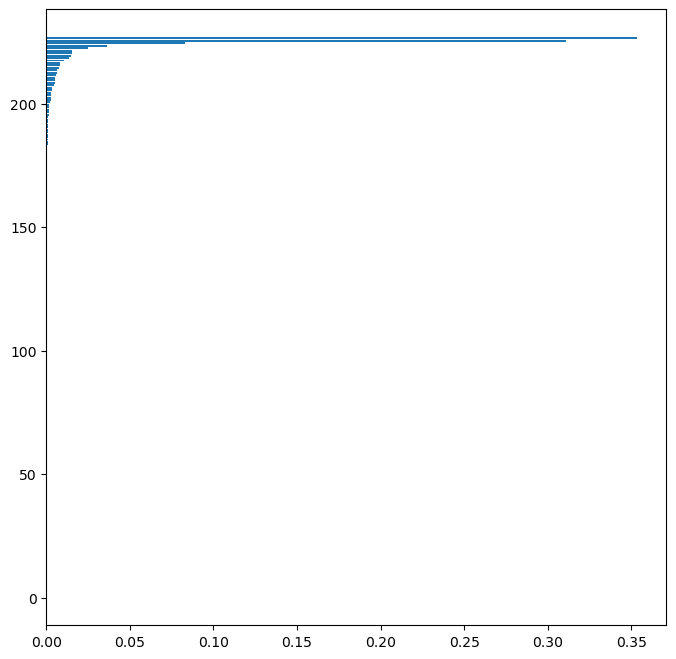

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
gbr = GBoost
gbr.fit(x_train,y_train)


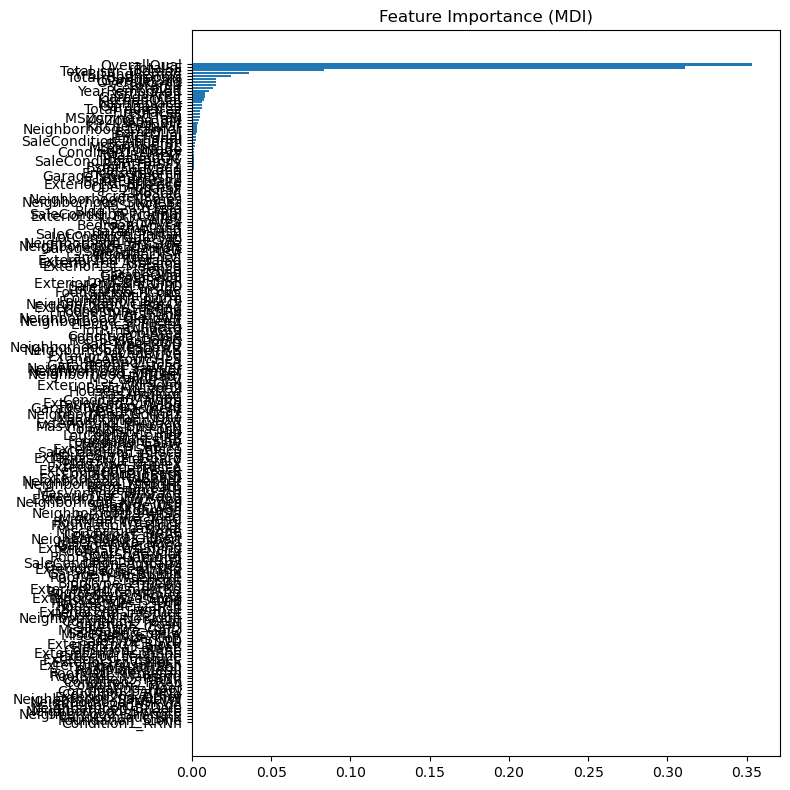

In [27]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(gbr, x_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

In [26]:
np.array(x_train.feature_names)

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [31]:
result['importances_mean'] = result['importances_mean'][:5]
result['importances_std'] = result['importances_std'][:5]
result['importances'] = result['importances'][:5]
result

{'importances_mean': array([5.08737606e-04, 1.34419586e-03, 1.59913509e-02, 4.57548488e-04,
        7.89057078e-05]),
 'importances_std': array([9.36248975e-05, 9.15934896e-05, 8.00891598e-04, 5.00832462e-05,
        1.18447834e-05]),
 'importances': array([[4.64870924e-04, 5.72995852e-04, 5.22486231e-04, 4.00476164e-04,
         6.41186013e-04, 3.24036336e-04, 4.68998770e-04, 5.04247520e-04,
         5.63346549e-04, 6.24731700e-04],
        [1.45728428e-03, 1.43036255e-03, 1.31166408e-03, 1.19161175e-03,
         1.27028746e-03, 1.27859751e-03, 1.32942708e-03, 1.35783271e-03,
         1.30456457e-03, 1.51032666e-03],
        [1.68563043e-02, 1.73065141e-02, 1.65090729e-02, 1.50581276e-02,
         1.54452604e-02, 1.53271765e-02, 1.58721606e-02, 1.47205625e-02,
         1.62092358e-02, 1.66090943e-02],
        [4.70839155e-04, 5.28966466e-04, 4.09020044e-04, 5.26347640e-04,
         4.63020148e-04, 4.99985818e-04, 3.84930178e-04, 3.83323704e-04,
         4.47970836e-04, 4.61080892e-04]

In [52]:
result = permutation_importance(gbr, x_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)

In [53]:
result1 = result.copy()

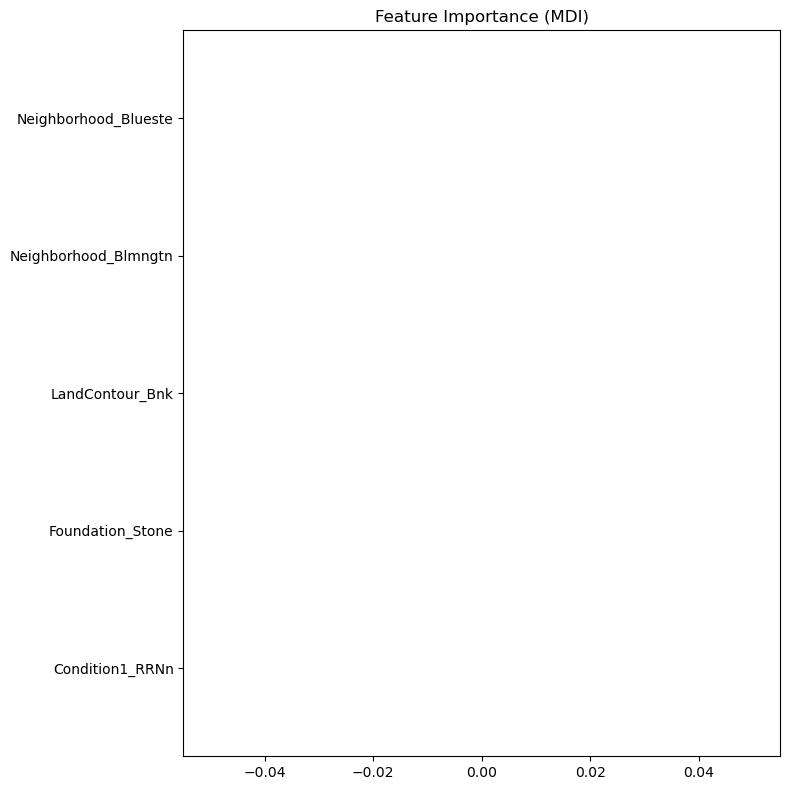

In [54]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[0:5]
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, (np.array(x_train.columns))[sorted_idx])
plt.title('Feature Importance (MDI)')
sorted_idx = result.importances_mean.argsort()[-5:]
fig.tight_layout()
plt.show()

In [35]:
np.array(x_train.columns)[0:5]

array(['MSSubClass', 'LotFrontage', 'LotArea', 'Alley', 'LotShape'],
      dtype=object)

In [41]:
sorted_idx = np.argsort(feature_importance)
sorted_idx[0:5]

array([113, 187,  71,  80,  81], dtype=int64)

In [42]:
pos

array([0.5, 1.5, 2.5, 3.5, 4.5])

In [48]:
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[0:5]
((np.array(x_train.columns))[0:5])[sorted_idx]

IndexError: index 113 is out of bounds for axis 0 with size 5

In [49]:
(np.array(x_train.columns))[0:5]

array(['MSSubClass', 'LotFrontage', 'LotArea', 'Alley', 'LotShape'],
      dtype=object)

In [50]:
sorted_idx

array([113, 187,  71,  80,  81], dtype=int64)

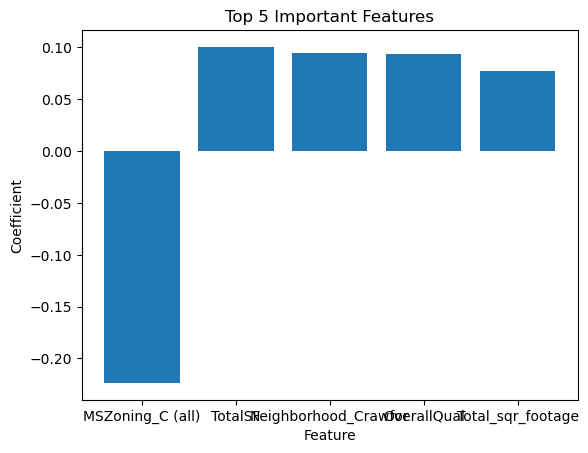

In [61]:
import matplotlib.pyplot as plt

lasso = lasso.fit(x_train, y_train)
# Get the coefficients of the model
coefs = lasso.named_steps['lasso'].coef_# Get the coefficients of the Lasso model

# Sort the coefficients in descending order of their absolute values
sorted_idx = np.argsort(np.abs(coefs))[::-1]

# Select the top 5 features
top_5_idx = sorted_idx[:5]
feature_names = np.array(x_train.columns)
top_5_features = [feature_names[i] for i in top_5_idx]
top_5_coefs = coefs[top_5_idx]

# Create the bar plot
plt.bar(top_5_features, top_5_coefs)

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 5 Important Features')

# Show the plot
plt.show()

In [62]:
top_5_features = ['11MSZoning_C (all)',
                  'TotalSF',
                  'Neighborhood_Crawfor',
                  'OverallQual',
                  'Total_sqr_footage']

['MSZoning_C (all)',
 'TotalSF',
 'Neighborhood_Crawfor',
 'OverallQual',
 'Total_sqr_footage']

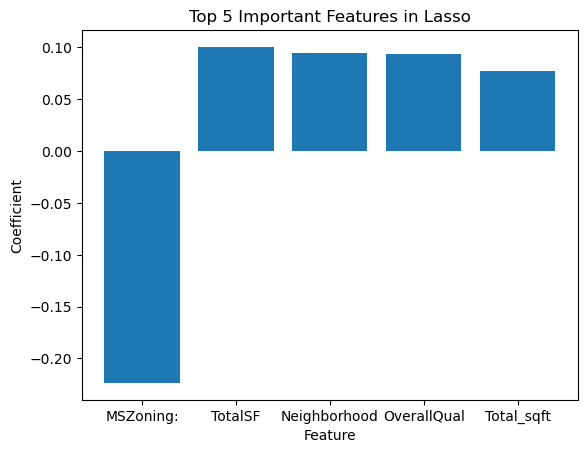

In [65]:
top_5_features = ['MSZoning:',
                  'TotalSF',
                  'Neighborhood',
                  'OverallQual',
                  'Total_sqft']
# Create the bar plot
plt.bar(top_5_features, top_5_coefs)

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 5 Important Features in Lasso')

# Show the plot
plt.show()

In [84]:
ridge = ridge.fit(x_train, y_train)
# Get the coefficients of the model
coefs = ridge.coef_.reshape(-1)# Get the coefficients of the Lasso model

# Sort the coefficients in descending order of their absolute values
sorted_idx = np.argsort(np.abs(coefs))[::-1]

# Select the top 5 features
top_5_idx = sorted_idx.reshape(-1)[0:5]
feature_names = np.array(x_train.columns)
top_5_features = [feature_names[i] for i in top_5_idx]
top_5_coefs = coefs[top_5_idx]

In [85]:
top_5_features

['MSZoning_C (all)',
 'OverallQual',
 'OverallCond',
 'YrBltAndRemod',
 'Neighborhood_StoneBr']

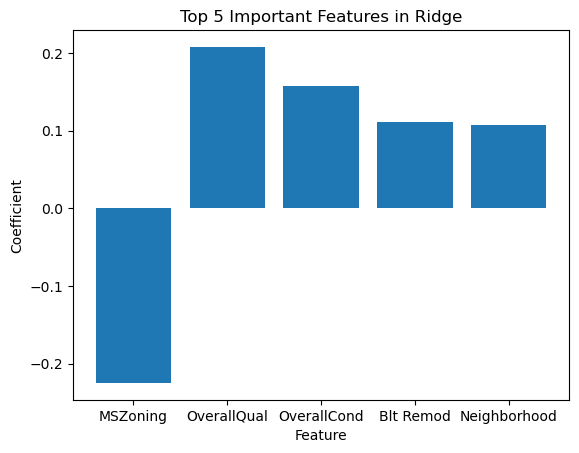

In [91]:
top_5_features = ['MSZoning',
                  'OverallQual',
                  'OverallCond',
                  'Blt Remod',
                  'Neighborhood']
# Create the bar plot
plt.bar(top_5_features, top_5_coefs)

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 5 Important Features in Ridge')

# Show the plot
plt.show()

In [98]:
ENet = ENet.fit(x_train, y_train)
# Get the coefficients of the model
coefs = ENet.named_steps['elasticnet'].coef_# Get the coefficients of the Lasso model

# Sort the coefficients in descending order of their absolute values
sorted_idx = np.argsort(np.abs(coefs))[::-1]

# Select the top 5 features
top_5_idx = sorted_idx[:5]
top_5_features = [feature_names[i] for i in top_5_idx]
top_5_coefs = coefs[top_5_idx]
top_5_features

['MSZoning_C (all)',
 'TotalSF',
 'Neighborhood_StoneBr',
 'Neighborhood_Crawfor',
 'Heating_Grav']

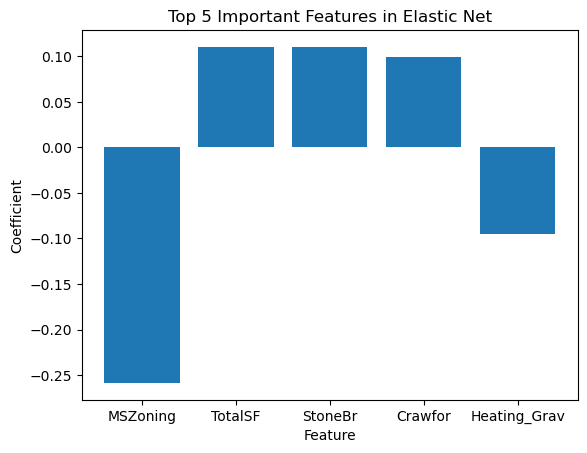

In [99]:
top_5_features = ['MSZoning',
                  'TotalSF',
                  'StoneBr',
                  'Crawfor',
                  'Heating_Grav']
# Create the bar plot
plt.bar(top_5_features, top_5_coefs)

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 5 Important Features in Elastic Net')

# Show the plot
plt.show()

In [101]:
# Get the feature importances of the model
importances = GBoost.feature_importances_

# Sort the feature importances in descending order
sorted_idx = np.argsort(importances)[::-1]

# Select the top 5 features
top_5_idx = sorted_idx[:5]
top_5_features = [feature_names[i] for i in top_5_idx]
top_5_importances = importances[top_5_idx]

top_5_features


['OverallQual',
 'TotalSF',
 'Total_sqr_footage',
 'YrBltAndRemod',
 'Total_Bathrooms']

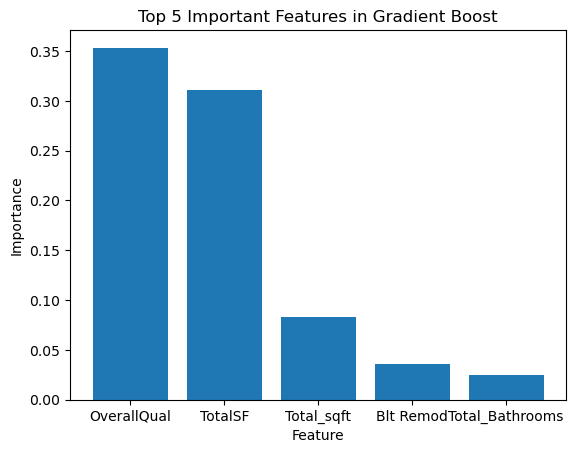

In [104]:
top_5_features =['OverallQual',
                 'TotalSF',
                 'Total_sqft',
                 'Blt Remod',
                 'Total_Bathrooms']
# Create the bar plot
plt.bar(top_5_features, top_5_importances)

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 5 Important Features in Gradient Boost')

# Show the plot
plt.show()

In [105]:
importances

array([5.74433383e-04, 1.37772160e-03, 1.50267182e-02, 4.64238242e-04,
       1.69607184e-04, 6.76609418e-05, 3.53339438e-01, 1.52842949e-02,
       3.57373790e-03, 1.07311717e-02, 4.41624880e-04, 2.84526466e-03,
       2.63799186e-04, 3.04340589e-03, 4.20938045e-04, 7.92406794e-04,
       1.02497057e-03, 9.16584646e-04, 7.65985298e-05, 1.02815092e-03,
       1.67783255e-03, 1.32641617e-03, 1.22012468e-03, 1.33946527e-02,
       5.17293142e-03, 7.09256730e-04, 2.21439811e-04, 8.04021226e-03,
       2.37482457e-05, 2.02968769e-05, 1.51539783e-04, 8.45807144e-05,
       4.27107153e-04, 3.33939271e-03, 7.55031251e-03, 1.47814132e-04,
       2.64594391e-03, 5.30226716e-03, 2.24662883e-04, 7.95207172e-03,
       4.08305479e-04, 1.53211832e-02, 6.44266159e-03, 2.48711016e-04,
       9.91113748e-04, 1.00303020e-04, 3.49953296e-04, 7.35569894e-04,
       9.61113314e-04, 1.20432839e-04, 6.16502061e-04, 1.47603469e-04,
       2.84491688e-04, 7.96107477e-05, 6.31519348e-04, 5.19360689e-04,
      